In [1]:
import numpy as np 
import pandas as pd 
import gc
from plotnine import *
from random import sample
import xgboost as xgb
from sklearn.metrics import f1_score, confusion_matrix, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold
import utils as u

In [2]:
dir = 'data/'
out = 'mid_output/'
train_numeric = dir + 'train_numeric.csv'
test_numeric = dir + 'test_numeric.csv'

# 

## 1. Basic information

In [5]:
response = pd.read_csv(train_numeric, usecols = ['Response'])
response_prop = response.groupby('Response').size().reset_index(name='counts')
response_prop['props'] = response_prop['counts'].transform(lambda x: x / float(x.sum()))
label_count = response_prop['counts']


In [4]:
# start_time = datetime.now()

numeric_cols = pd.read_csv(train_numeric, nrows = 1).columns.to_list()
numeric_cols = list(set(numeric_cols) - set(['Id', 'Response']))
number_of_col = len(numeric_cols)

numeric_explor = pd.DataFrame()

for i in range(number_of_col):
    col = []
    col.append(numeric_cols[i])
    
    temp_numeric = pd.DataFrame()
    temp_numeric = pd.read_csv(train_numeric, usecols = col)
    temp_numeric = pd.concat([temp_numeric, response], axis = 1).dropna(axis = 0, how = 'any')
    
    temp_numeric = temp_numeric.groupby('Response').size().reset_index(name='counts')
    temp_numeric = temp_numeric.assign(
                props = temp_numeric['counts'].transform(lambda x: x / float(x.sum())),
                WOE = np.log((temp_numeric['counts'][1]/label_count[1]) / (temp_numeric['counts'][0]/label_count[0])),
                IV = ((temp_numeric['counts'][1]/label_count[1]) - (temp_numeric['counts'][0]/label_count[0])) * np.log((temp_numeric['counts'][1]/label_count[1]) / (temp_numeric['counts'][0]/label_count[0])),
                feature = col[0],
                number_of_data = temp_numeric['counts'].sum(),
                number_of_missing_data = len(response) - temp_numeric['counts'].sum(),
                prop_of_missing = (len(response) - temp_numeric['counts'].sum())/ len(response)
        )[temp_numeric['Response'] == 1]
    
    numeric_explor = pd.concat([numeric_explor, temp_numeric], axis = 0)
    del temp_numeric
    gc.collect()

numeric_explor.to_csv(out + 'numeric_explor.csv')


# end_time = datetime.now()
# print('Duration: {}'.format(end_time - start_time))


In [6]:
numeric_explor = pd.read_csv(out + 'numeric_explor.csv')

numeric_explor = numeric_explor.sort_values('props', ascending = False)
numeric_explor['props'] = numeric_explor['props']/ response_prop['props'][1] #response_prop['props'][1] is total faile rate [0.0058].
numeric_explor['line'] = numeric_explor['feature'].apply(lambda x: x[0:2])
numeric_explor['station'] = numeric_explor.apply(lambda x: x.feature[3: x.feature.find('_', 3, 8)], axis = 1)
numeric_explor['station'] = numeric_explor.apply(lambda x: 'S' + ('00' + x.station.lstrip('S'))[-2:], axis = 1)
numeric_explor['feat'] = numeric_explor.apply(lambda x: x.feature[(x.feature.find('_', 3, 10) + 2): 12], axis = 1)
numeric_explor['feat'] = numeric_explor.apply(lambda x: 'F' + ('00000' + x.feat)[-4:], axis = 1)
numeric_explor['higher_base'] = np.where(numeric_explor['props'] >= 1, 1, 0)
numeric_explor['higher_base'] = numeric_explor['higher_base'].astype('category')

In [7]:
numeric_explor['higher_base1'] = numeric_explor['higher_base'].astype('int8')
numeric_explor['line'] = numeric_explor['line'].astype('category')
line_prop_failur = numeric_explor.groupby(['line', 'higher_base'])['higher_base1'].size().reset_index()
line_porp_failur = line_prop_failur.groupby('line')['higher_base1'].apply(lambda x: x/sum(x)).reset_index()
line_porp_failur['index'] = pd.DataFrame(sorted(sorted(numeric_explor.line.unique()) * 2))
line_porp_failur = line_porp_failur.iloc[1::2, :]
line_porp_failur['higher_base1'] = line_porp_failur['higher_base1'].apply(lambda x: str(round(x*100, 2)) + '%')
porp_failur = line_porp_failur.set_index('index')

In [8]:
number_stations = numeric_explor.groupby('line')['station'].unique().apply(lambda x: len(x))
number_features = numeric_explor.groupby('line')['station'].size()

print('Number of stations', number_stations)
print('================================')
print('Number of features', number_features)
print('================================')
print('Number of features', porp_failur.iloc[:,0])


Number of stations line
L0    24
L1     2
L2     3
L3    21
Name: station, dtype: int64
Number of features line
L0    168
L1    513
L2     42
L3    245
Name: station, dtype: int64
Number of features index
L0      0.0%
L1     46.0%
L2    100.0%
L3    42.86%
Name: higher_base1, dtype: object


### 1.1 Information of numeric data

In [11]:
summary_numeric = {'Line': ['L0', 'L1', 'L2', 'L3'],
                   'Station': number_stations,
                   'Feature': number_features,
                   'Percentage of fail ratio > 1': porp_failur.iloc[:,0]
                  }
summary_numeric = pd.DataFrame(summary_numeric).reset_index(drop=True)
summary_numeric

,Line,Station,Feature,Percentage of fail ratio > 1
0,L0,24,168,0.0%
1,L1,2,513,46.0%
2,L2,3,42,100.0%
3,L3,21,245,42.86%


# 2.Feature engineering

In [ ]:
# Load data
data = u.load_data(train_numeric, 2.5*10**5, 1.2*10**6, pd.read_csv(train_numeric, nrows = 1).columns)

### 2.1 Visualize missing/ non missing data

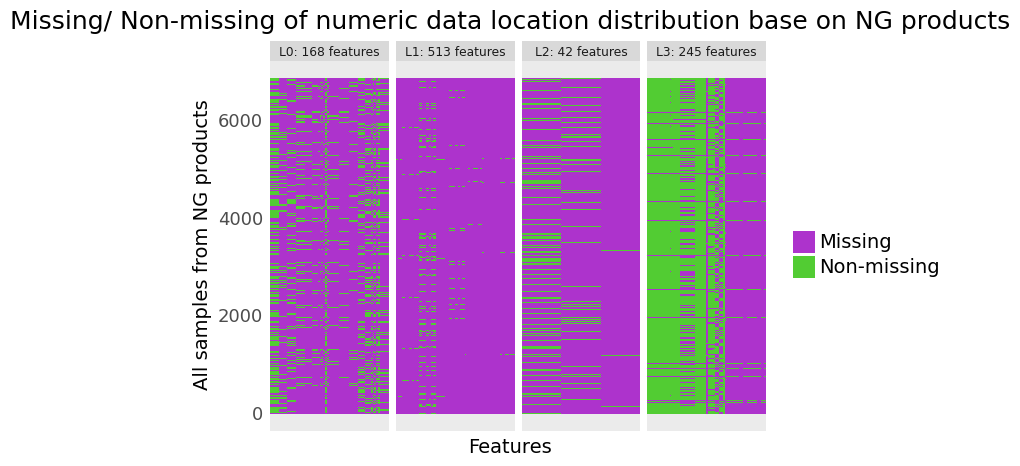

<ggplot: (-9223371891674468544)>

In [28]:
num_of_features = {'L0': "L0: 168 features",
                   'L1': "L1: 513 features",
                   'L2': "L2: 42 features",
                   'L3': "L3: 245 features"}


ng_product = data[data['Response'] == 1].copy()
hm_data = u.data_for_hmplot(ng_product, ng_product.shape[0] + 1)
del ng_product
gc.collect()
heatmap_ng_product = u.heatmap(hm_data, num_of_features, 'All samples from NG products','Missing/ Non-missing of numeric data location distribution base on NG products')  
heatmap_ng_product  

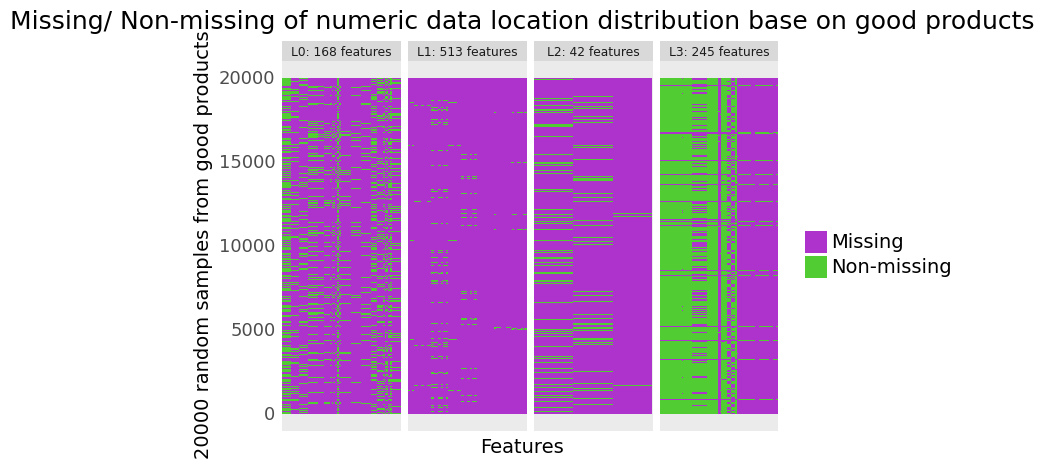

<ggplot: (-9223371891672959184)>

In [14]:
num_of_features = {'L0': "L0: 168 features",
                   'L1': "L1: 513 features",
                   'L2': "L2: 42 features",
                   'L3': "L3: 245 features"}

row = 20000

good_product = data[data['Response'] != 1].copy()
index = sample(range(good_product.shape[0]), row)
good_product = good_product.iloc[index, :]
hm_data = u.data_for_hmplot(good_product, row + 1)
del good_product
gc.collect()

heatmap_good_product = u.heatmap(hm_data, num_of_features, '20000 random samples from good products')  
heatmap_good_product  

In [25]:
del heatmap_good_product
gc.collect()

The propotions of failure product is extremly low at 0.58%. The training dataset is absoultly a imbalance data. For this dataset we could use oversampling or undersampling techniqes as training models.

c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plotnine-save-9223371913573246624.svg


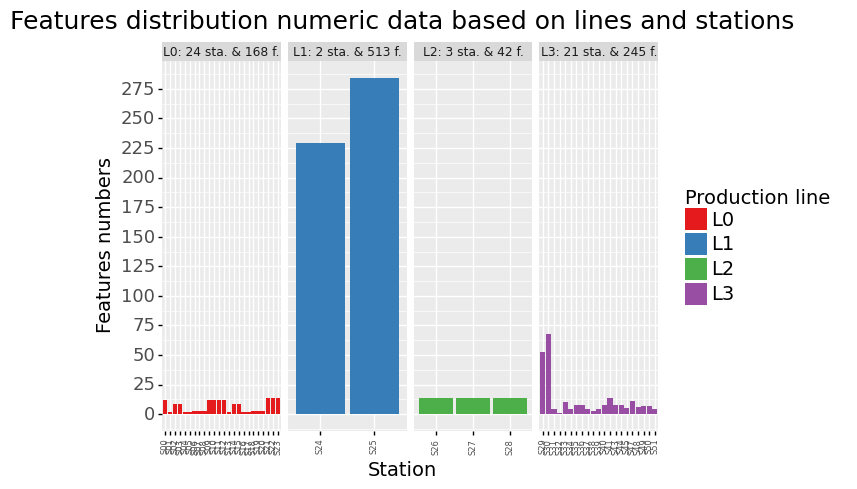

<ggplot: (-9223371913573246624)>

In [9]:
line_information = {'L0': "L0: 24 sta. & 168 f.",
                    'L1': "L1: 2 sta. & 513 f.",
                    'L2': "L2: 3 sta. & 42 f.",
                    'L3': "L3: 21 sta. & 245 f."}

g = u.draw_feature_distribution(numeric_explor, line_information, 'numeric data')
ggsave(file="date_station_number.svg", plot = g, width=10, height=8, dpi = 500,format = 'svg')
g

c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plotnine-save-9223371877337910788.svg


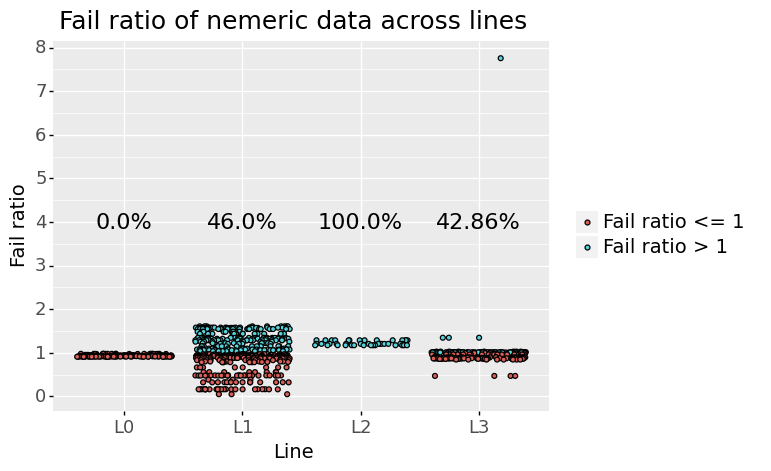

<ggplot: (-9223371877337910788)>

In [12]:
g = (
    ggplot(numeric_explor, aes(x = 'line', y = 'props', fill = 'higher_base')) +
    geom_jitter(aes(aplha = 0.01)) +
    annotate("text", x = 1, y = 4, label = line_porp_failur.iloc[0, 1], size = 16) +
    annotate("text", x = 2, y = 4, label = line_porp_failur.iloc[1, 1], size = 16) +
    annotate("text", x = 3, y = 4, label = line_porp_failur.iloc[2, 1], size = 16) +
    annotate("text", x = 4, y = 4, label = line_porp_failur.iloc[3, 1], size = 16) +
    scale_fill_hue(name = " ", labels = ["Fail ratio <= 1", "Fail ratio > 1"]) +
    scale_y_continuous(breaks = range(0, 9, 1)) +
    labs(x = 'Line', y = 'Fail ratio') +
    theme(axis_text = element_text(size = 13),
          axis_title = element_text(size = 14),
          legend_text = element_text(size = 14),
          plot_title = element_text(size = 18)
          ) +
    ggtitle('Fail ratio of nemeric data across lines') 

)
ggsave(file="Fail ratio of nemeric data across lines.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')
g

c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plotnine-save-9223371886631738188.svg


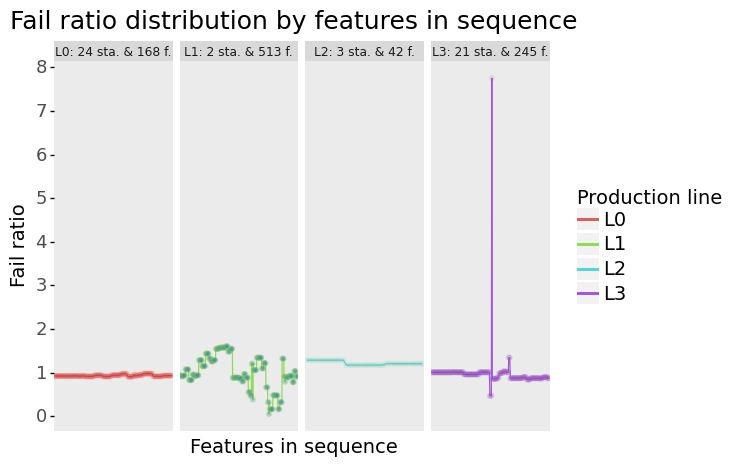

<ggplot: (-9223371886631738188)>

In [416]:
numeric_explor.sort_values(by = ['line', 'station', 'feat'], inplace = True)

line_information = {'L0': "L0: 24 sta. & 168 f.",
                    'L1': "L1: 2 sta. & 513 f.",
                    'L2': "L2: 3 sta. & 42 f.",
                    'L3': "L3: 21 sta. & 245 f."}

g = (
    ggplot(numeric_explor, aes(x = 'feat', y = 'props', group = 'line', 
                               fill = 'line', colour = 'line'))
    + geom_line()
    + geom_point(alpha = 0.1, show_legend = False)
    + theme(axis_text_x = element_blank(),
            axis_text_y = element_text(size = 13),
            axis_title = element_text(size = 14),
            axis_ticks_minor_x = element_blank(),
            axis_ticks_major_x = element_blank(),
            legend_text = element_text(size = 14),
            legend_title = element_text(size = 14),
            plot_title = element_text(size = 18),
            strip_text = element_text(),
            panel_grid_major = element_blank(), 
            panel_grid_minor = element_blank())
    + scale_y_continuous(breaks = range(0, 9, 1))
    + facet_wrap('~line', nrow = 1, ncol = 4, scales = 'free_x', labeller = line_information)
    + scale_fill_brewer(name = '', type="qual", palette="Set1")
    + labs(x = 'Features in sequence', y = 'Fail ratio', colour = "Production line")
    + ggtitle('Fail ratio distribution by features in sequence')

)
ggsave(file="Fail ratio distribution by features in sequence.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')
g

## Feature selection

In [11]:
# drop duplicate columns 966 (not include Id and Response) - > 925

data_wo_duplicate = data.sample(frac = 0.2, random_state = 3)
data_wo_duplicate = data_wo_duplicate.T.drop_duplicates().T
data_wo_duplicate_col = data_wo_duplicate.columns.to_list()
data_wo_duplicate_col = list(set(data_wo_duplicate_col) - set(['Id', 'Response']))
data_wo_duplicate_col = pd.DataFrame({'feature':data_wo_duplicate_col})
numeric_explor_wo_duplicate = pd.merge(data_wo_duplicate_col, numeric_explor, how = 'left', on = 'feature')

In [12]:
numeric_feat_data = numeric_explor_wo_duplicate[numeric_explor_wo_duplicate['IV'] > 0.02]
numeric_feat_data.to_csv(out + 'numeric_selected_features.csv')


In [11]:
numeric_feat_data = pd.read_csv(out + 'numeric_selected_features.csv')
numeric_feat_data

,Unnamed: 0,feature,Response,counts,props,WOE,IV,number_of_data,number_of_missing_data,prop_of_missing
0,9,L3_S32_F3850,1,1106,0.045064,2.088573,0.294206,24543,1159204,0.979267
1,39,L3_S33_F3873,1,5546,0.004975,-0.156133,0.021271,1114695,69052,0.058333
2,62,L1_S24_F1539,1,1190,0.008976,0.437983,0.026872,132572,1051175,0.888006
3,86,L3_S33_F3867,1,5546,0.004975,-0.156133,0.021271,1114695,69052,0.058333
4,139,L1_S24_F1844,1,1192,0.008968,0.437017,0.026810,132922,1050825,0.887711
5,156,L1_S24_F1838,1,1192,0.008968,0.437017,0.026810,132922,1050825,0.887711
6,195,L1_S24_F1836,1,1192,0.008968,0.437017,0.026810,132922,1050825,0.887711
7,257,L3_S33_F3865,1,5546,0.004975,-0.156133,0.021271,1114695,69052,0.058333
8,303,L1_S24_F1520,1,1190,0.008976,0.437983,0.026872,132572,1051175,0.888006
9,368,L1_S24_F1567,1,1192,0.008969,0.437116,0.026821,132909,1050838,0.887722


## 3. Feature importance


In [ ]:
col = pd.read_csv(train_numeric, nrows = 1).columns.to_list()
col[451:970]

In [54]:
del data
gc.collect()
data = u.load_data(train_numeric, 2.5*10**5, 1.2*10**6, f12)

In [55]:

response = pd.read_csv(train_numeric, usecols = ['Id', 'Response'])
data = pd.concat([data, response], axis = 1)


In [56]:
np.random.seed(10)
data = data.sample(frac = 1)
gc.collect()

21

In [57]:
X = data.drop(['Id', 'Response'], axis = 1)
y = data['Response']
print(X.shape)
print(y.shape)

(1183747, 239)
(1183747,)


In [58]:
def best_thr_mcc(preds, dtrain):
    labels = dtrain.get_label()
    thresholds = np.linspace(0.01, 0.99, 50)
    mcc = np.array([matthews_corrcoef(labels, preds > thr)
                   for thr in thresholds])
    best_thr = thresholds[np.argmax(mcc)]
    best_score = mcc.max()
    return best_thr, best_score

kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)
mcc_score = []
g_means_scores = []
f1_scores = []
thresh = []

num_round = 50
params = {'colsample_bytree':0.8, 
          'eta':0.1,
          'max_depth': 12,
          'subsample': 0.9,
          'min_child_weight': 15, 
          'objective': 'binary:logistic',
          'random_state': 71,
          'silent': 0
            }

for tr_idx, va_idx in kf.split(X, y):
    tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
    tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]

    dtrain = xgb.DMatrix(tr_x, label = tr_y)
    dvalid = xgb.DMatrix(va_x, label = va_y)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

    model = xgb.train(params, dtrain, 
                      num_round, 
                      evals = watchlist, 
                      verbose_eval=True, 
                      early_stopping_rounds=10, 
                      feval = u.evalerror)
    
    va_pred = model.predict(dvalid)
    
    # fpr, tpr, thresholds = roc_curve(va_y.values, va_pred)
    # j = tpr - fpr
    # ix = np.argmax(j)
    # best_thresh = thresholds[ix]
    # y_pred = np.array([1 if y_prob > best_thresh else 0 for y_prob in va_pred])
    # mcc = matthews_corrcoef(va_y.values, y_pred)
    
    best_thresh, mcc_value= u.best_thr_mcc(va_pred, dvalid)
    y_pred = np.array([1 if y_pro > best_thresh else 0 for y_pro in va_pred])

    tn, fp, fn, tp = confusion_matrix(va_y, y_pred).ravel()
    spec = tn / (tn+fp)
    sens = tp / (tp + fn)
    g_means = np.sqrt(spec * sens)
    fmeasure = f1_score(va_y, y_pred)

    print('mcc value: {}'.format(mcc_value))
    print('g_means value: {}'.format(g_means))
    print('f1_score value: {}'.format(fmeasure))
    
    thresh.append(best_thresh)
    mcc_score.append(mcc_value)
    g_means_scores.append(g_means)
    f1_scores.append(fmeasure)

    
    gc.collect()

print('avg_MCC:', round(np.mean(mcc_score), 3))
print('avg_g_means:', round(np.mean(g_means_scores), 3))
print('avg_f1_score:', round(np.mean(f1_scores), 3))


[00:40:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:40:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.59993	train-error:-0.20164	eval-logloss:0.60030	eval-error:-0.19442
[1]	train-logloss:0.52406	train-error:-0.20035	eval-logloss:0.52415	eval-error:-0.19198
[2]	train-logloss:0.46042	train-error:-0.20195	eval-logloss:0.46065	eval-error:-0.17886
[3]	train-l

In [61]:
# model = xgb.Booster()
# model.load_model("numeric_xgb_model.json")
fscore = model.get_score(importance_type = 'total_gain')

keys = list(fscore.keys())
values = list(fscore.values())
feat_imp = pd.DataFrame({'feature': keys, 'scores': values}, index=keys).sort_values(by = "scores", ascending=True)
feat_imp['feature'] = pd.Categorical(
feat_imp.feature, categories=pd.unique(feat_imp.feature))
feat_imp['score'] = feat_imp['scores'].transform(lambda x: (x/float(x.sum())*100))
# feat_imp.to_csv(out + 'numeric_xgb_feature_importance.csv')
feat_imp

,feature,scores,score
L1_S25_F2046,L1_S25_F2046,0.065918,0.000270
L1_S24_F1808,L1_S24_F1808,0.193359,0.000792
L1_S24_F1738,L1_S24_F1738,0.370605,0.001519
L1_S24_F1753,L1_S24_F1753,0.379734,0.001556
L1_S24_F1818,L1_S24_F1818,1.127472,0.004620
...,...,...,...
L3_S29_F3407,L3_S29_F3407,1211.072876,4.962606
L1_S24_F1723,L1_S24_F1723,1673.209351,6.856300
L1_S24_F1846,L1_S24_F1846,1721.365845,7.053631
L3_S33_F3865,L3_S33_F3865,2901.273193,11.888530


Saving 10 x 8 in image.
Filename: plotnine-save-9223371888965391976.svg


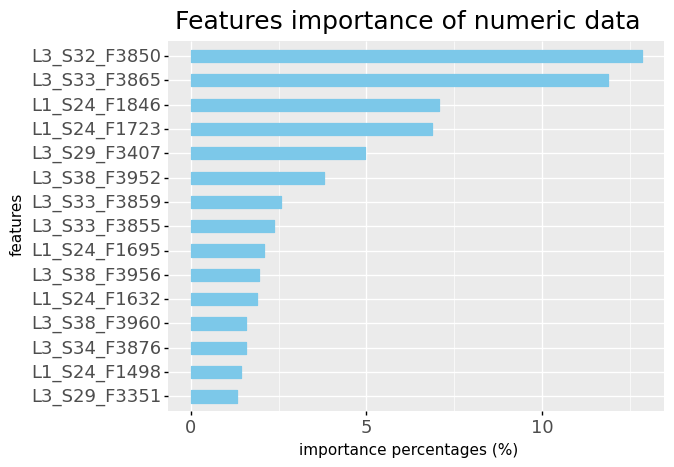

<ggplot: (-9223371888965391976)>

In [66]:
# feature importance
g = (
    ggplot(feat_imp.iloc[-15:, :])
    + geom_bar(aes(x = 'feature', y = 'score'), stat = "identity", color='#7cc8e9', fill='#7cc8e9', width = 0.5)
    + theme(axis_text_x = element_text(angle = 0, size = 13),
            axis_text_y=element_text(size=13),
            plot_title=element_text(size=18))
    # + scale_y_continuous(breaks = range(0, 1, 0.2))
    + coord_flip()
    + labs(x = 'features',y = 'importance percentages (%)')
    + ggtitle('Features importance of numeric data')
)
ggsave(file="Features importance of numeric data.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')
g

In [51]:
# output top 15 of important features
features = list(feat_imp.iloc[-15:, 0])
features.append('Id')

numeric_train = pd.read_csv(train_numeric, usecols = features)
numeric_test = pd.read_csv(test_numeric, usecols = features)

numeric_train.to_csv(out + 'numeric_train_features.csv')
numeric_test.to_csv(out + 'numeric_test_features.csv')

In [47]:
features = list(set(features) - set(['Id']))
features = u.get_line_information(features)

number_stations = features.groupby('line')['station'].unique().apply(lambda x: len(x))
number_features = features.groupby('line')['station'].size()
print('number_stations:',number_stations)
print('number_features:', number_features)

number_stations: line
L1    1
L3    5
Name: station, dtype: int64
number_features: line
L1     4
L3    11
Name: station, dtype: int64
